In [63]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

<p>Importing the data and cleaning the data</p>

In [64]:
data = pd.read_csv('./Data/data.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [66]:
data = data.set_index('EmployeeNumber')
data.loc[data['Attrition'] == 'Yes', 'Attrition'] = 1
data.loc[data['Attrition'] == 'No', 'Attrition'] = 0
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,1,80,0,8,0,1,6,4,0,5
2,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,...,4,80,1,10,3,3,10,7,1,7
4,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
5,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,...,3,80,0,8,3,3,8,7,3,0
7,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,4,80,1,6,3,3,2,2,2,2


<p>Dropping columns that do not add value and creating dummy variables.</p>

In [68]:
data.drop(['EmployeeCount', 'Over18'],axis=1)
df = pd.get_dummies(data, columns=['BusinessTravel', 'Department','EducationField', 'Gender'])

In [69]:
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,1,1102,1,2,1,2,94,3,2,...,0,1,0,1,0,0,0,0,1,0
2,49,0,279,8,1,1,3,61,2,2,...,1,0,0,1,0,0,0,0,0,1
4,37,1,1373,2,2,1,4,92,2,1,...,1,0,0,0,0,0,1,0,0,1
5,33,0,1392,3,4,1,4,56,3,1,...,1,0,0,1,0,0,0,0,1,0
7,27,0,591,2,1,1,1,40,3,1,...,1,0,0,0,0,1,0,0,0,1


In [70]:
X = df.drop(['Attrition'], axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<p>Quantifying the severity of multicollinearity by monitoring the variance inflation factors for each variable and removing the variables that are highly correlated with other variables.</p>

In [71]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [72]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [73]:
final_iv, IV = data_vars(X_train, y_train)

In [74]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

In [75]:
def iterate_vif(df, vif_threshold=3, max_vif=4):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Gender_Male with VIF of 68.000000
Iteration # 2
Removing JobLevel with VIF of 53.100000
Iteration # 3
Removing Age with VIF of 28.900000
Iteration # 4
Removing Department_Research & Development with VIF of 16.000000
Iteration # 5
Removing JobInvolvement with VIF of 11.700000
Iteration # 6
Removing YearsAtCompany with VIF of 10.000000
Iteration # 7
Removing TotalWorkingYears with VIF of 8.700000
Iteration # 8
Removing JobSatisfaction with VIF of 5.900000
Iteration # 9
Removing YearsInCurrentRole with VIF of 5.500000
Iteration # 10
Removing EnvironmentSatisfaction with VIF of 5.300000
Iteration # 11
Removing DailyRate with VIF of 4.200000
Iteration # 12
Removing MonthlyIncome with VIF of 3.300000
Iteration # 13
Complete


In [76]:
X_train=final_df

<p>Running a logistic regression model and analyzing the ROC curve.</p>

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [78]:
X_test=X_test[X_train.columns]

Accuracy of logistic regression classifier on test set: 0.86

Confusion matrix: 
 [[377   3]
 [ 58   3]]

Classification report: 
              precision    recall  f1-score   support

          0       0.87      0.99      0.93       380
          1       0.50      0.05      0.09        61

avg / total       0.82      0.86      0.81       441



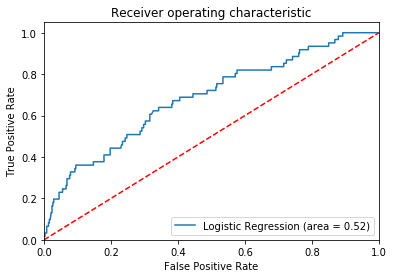

In [79]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [80]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.568097497842968

In [81]:
conf2 = confusion_matrix(y_test, y_pred2)

In [90]:
print('Accuracy of Random Forest Classifier classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Random Forest Classifier classifier on test set: 0.84


In [82]:
conf2

array([[357,  23],
       [ 49,  12]], dtype=int64)

In [92]:
rf_2 = RandomForestClassifier(random_state = 42) 

In [93]:
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [100, 500, 1000],
           "max_depth" : [10, 50, 100],
           "min_samples_leaf" : [5, 50, 100]}

In [94]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_2, param_distributions=param_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print (rf_random.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished


{'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 10}


In [95]:
print('Accuracy of Random Forest Classifier classifier on test set: {:.2f}'.format(rf_random.score(X_test, y_test)))

Accuracy of Random Forest Classifier classifier on test set: 0.86


In [96]:
y_pred3 = rf_random.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

0.5206427955133736

In [97]:
conf3 = confusion_matrix(y_test, y_pred3)
conf3

array([[377,   3],
       [ 58,   3]], dtype=int64)

In [87]:
# Use a grid over parameters of interest
param_grid_2 = { 
           "n_estimators" : [1000, 5000, 10000],
           "max_depth" : [50],
           "min_samples_leaf" : [1, 5]}

rf_random_2 = RandomizedSearchCV(estimator=rf_2, param_distributions=param_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
rf_random_2.fit(X_train, y_train)
print (rf_random_2.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished


{'n_estimators': 1000, 'min_samples_leaf': 5, 'max_depth': 50}


In [101]:
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, max_depth=50, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred4 = rf_classifier.predict(X_test)

In [102]:
print('Accuracy of Random Forest Classifier classifier on test set: {:.2f}'.format(rf_classifier.score(X_test, y_test)))

Accuracy of Random Forest Classifier classifier on test set: 0.86
